In [29]:
from collections import Counter
import os

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 100)

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']


In [30]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-30-8592cd22b625>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [31]:
# Plot an example tree
#Source.from_file('../kth_data_science_assignment_4_aug2020/data/atac/train_atac_results/dot_files_all/0.01_map9.gv')

# Load clone key

In [32]:
clones_map_raw = pd.read_csv('../kth_data_science_assignment_4_aug2020/data/atac/test_atac_results/matrix_output/sample_order_test.txt')
clones_map_raw['node_name'] = 's' + clones_map_raw['tree_id'].astype(str)
clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,D,s1,P9855_2085_S108_L004_ac.txt,ss1
2,E,s2,P9855_2091_S114_L004_ac.txt,ss2
3,D,s3,P9855_2093_S116_L005_ac.txt,ss3
4,E,s4,P9855_2096_S119_L005_ac.txt,ss4
5,F,s5,P9855_2101_S124_L006_ac.txt,ss5
6,F,s6,P9855_2102_S125_L006_ac.txt,ss6


In [33]:
clones_map_raw.clone.value_counts()

F       2
E       2
D       2
bulk    1
Name: clone, dtype: int64

In [34]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [35]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

F       2
E       2
D       2
bulk    1
Name: clone, dtype: int64

# Load all trees

In [36]:
error_rates = [0.0001, 0.00015, 0.0003, 0.0008, 0.01]

n_trees = [45, 31, 61, 2470, 72]

In [37]:
MAX_TREES_PER_ERROR_RATE = 10

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../kth_data_science_assignment_4_aug2020/data/atac/test_atac_results/tree_output//{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        all_trees[error_rate].append(tree)

# Performance

In [39]:
performance = pd.DataFrame(
    data={'log_error_rate': np.log(error_rates)},
    index=error_rates,
)

In [40]:
#performance.index

In [41]:
performance['log_lhood'] = [-474.37767433748706, -164.20267569069466, -20.840662406837435, -6.6061496790899152, -3.9206487302427364]

In [42]:
performance['n_mutations'] = [127, 59, 21, 14, 10]

In [43]:
performance['n_trees'] = [45, 31, 61, 2470, 72]

In [44]:
performance.drop(columns='log_error_rate')

,log_lhood,n_mutations,n_trees
0.00010,-474.377674,127,45
0.00015,-164.202676,59,31
0.00030,-20.840662,21,61
0.00080,-6.606150,14,2470
0.01000,-3.920649,10,72


# Average purity

In [45]:
def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

In [46]:
t = all_trees[0.00015][0]

In [47]:
clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
clones_count

,s0,s1,s2,s3,s4,s5,s6,38,32,6,1,58,27,57,45,39,18,49,31,17,2,21,19,36,50,16,8,55,14,9,23,53,37,4,26,5,54,40,59,35,48,25,33,44,56,3,15,41,43,12,29,28,24,13,7,47,11,20,52,10,30,51,46,42,34,22,60
bulk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
D,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,2,2,2,2,2,2,2
E,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,2,2,2,2,2,2,2,2
F,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,0,0,0,0,0,0,2,2,2,2,2,2,2,2


In [48]:
p = purity(clones_count)
p = p[[c for c in p.columns if c not in clones_map.keys()]]
p

,38,32,6,1,58,27,57,45,39,18,49,31,17,2,21,19,36,50,16,8,55,14,9,23,53,37,4,26,5,54,40,59,35,48,25,33,44,56,3,15,41,43,12,29,28,24,13,7,47,11,20,52,10,30,51,46,42,34,22,60
bulk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857
D,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.333333,1.0,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.285714
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.285714
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.285714


In [49]:
performance['avg_purity'] = 0
performance['frac_purity_100'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    for t in trees:
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        mutations = [c for c in clones_count.columns if c not in clones_map.keys()]
        p = purity(clones_count)[mutations]
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100'] = frac_purities_100[0]

# Avg purity of nodes with >1 sample

In [50]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]


# Plots

In [51]:
performance.head()

,log_error_rate,log_lhood,n_mutations,n_trees,avg_purity,frac_purity_100,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample
0.00010,-9.210340,-474.377674,127,45,0.836868,0.726562,0.646086,0.406780
0.00015,-8.804875,-164.202676,59,31,0.808095,0.683333,0.696992,0.500000
0.00030,-8.111728,-20.840662,21,61,0.732684,0.590909,0.690476,0.526316
0.00080,-7.130899,-6.606150,14,2470,0.741270,0.600000,0.741270,0.600000
0.01000,-4.605170,-3.920649,10,72,0.698701,0.545455,0.698701,0.545455


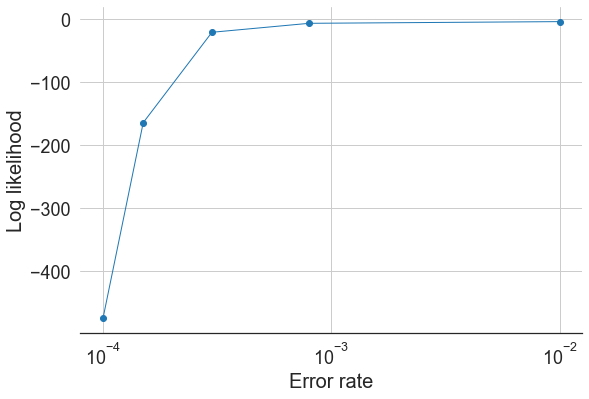

In [57]:
with plot_style(figsize=(9, 6), ticklabelsize=18, labelsize=20):
    performance.log_lhood.plot(marker='o', lw=1)
    plt.grid(axis='both')
    plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Log likelihood')
    plt.savefig('figs/performance/test_atac_log_lhood.png', dpi=300)

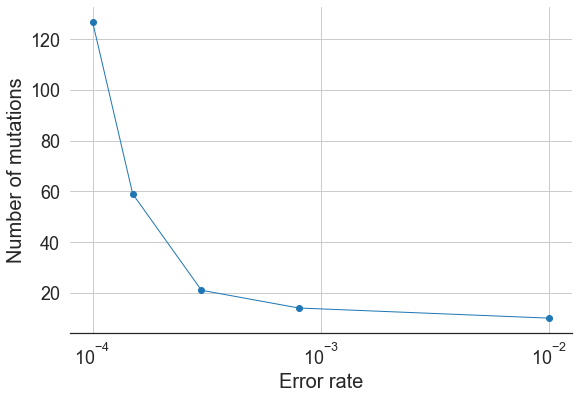

In [58]:
with plot_style(figsize=(9, 6), ticklabelsize=18, labelsize=20):
    performance.n_mutations.plot(marker='o', lw=1)
    plt.grid(axis='both')
    plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Number of mutations')
    plt.savefig('figs/performance/test_atac_n_mutations.png', dpi=300)

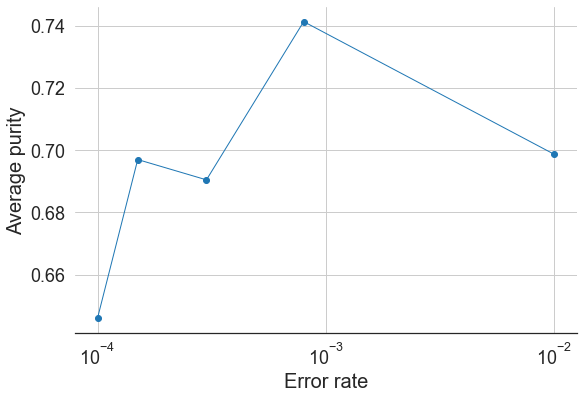

In [60]:
with plot_style(figsize=(9, 6), ticklabelsize=18, labelsize=20):
    performance.avg_purity_more_than_one_sample.plot(marker='o', lw=1)
    plt.grid(axis='both')
    plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Average purity')
    axes = plt.gca()
    #axes.set_ylim([0,1])
    plt.savefig('figs/performance/test_atac_avg_purity.png', dpi=300)

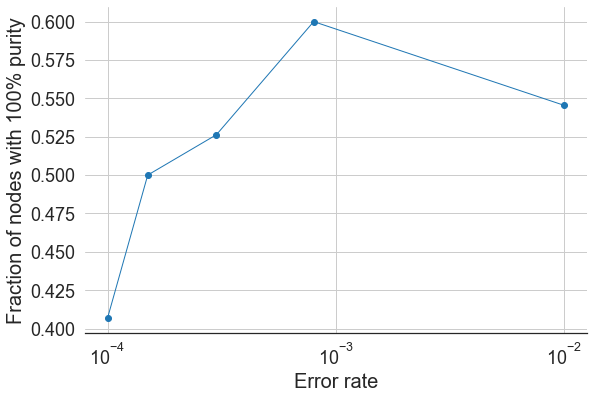

In [61]:
with plot_style(figsize=(9, 6), ticklabelsize=18, labelsize=20):
    performance.frac_purity_100_more_than_one_sample.plot(marker='o', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Fraction of nodes with 100% purity')
    plt.xscale('log')
    plt.savefig('figs/performance/test_atac_frac_pure_nodes.png', dpi=300)
